In [27]:
# this part wasn't in the initial hw files, but it's on the rubric?
# import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# no url because no internet, read csv into df
application_df = pd.read_csv("Resources/charity_data.csv")
# aug df to remove ID columns
application_df = application_df.drop(columns = ['EIN', 'NAME'])

In [28]:
# determine the number of unique values in each column.
for x in application_df.columns:
    print(x, len(application_df[x].unique()))

APPLICATION_TYPE 17
AFFILIATION 6
CLASSIFICATION 71
USE_CASE 5
ORGANIZATION 4
STATUS 2
INCOME_AMT 9
SPECIAL_CONSIDERATIONS 2
ASK_AMT 8747
IS_SUCCESSFUL 2


In [29]:
# instead of binning for just application_type and classification
# let's try binning for application_type and ask_amt
# also instead of setting the threshold at 700 for application_type, let's try 157
application_bins = application_df['APPLICATION_TYPE'].value_counts()
application_types_to_replace = list(application_bins[application_bins < 157].index)

# replace values under threshold in df
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"freq_u157")

# check for binning success
application_df['APPLICATION_TYPE'].value_counts()

APPLICATION_TYPE
T3           27037
T4            1542
T6            1216
T5            1173
T19           1065
T8             737
T7             725
T10            528
freq_u157      276
Name: count, dtype: int64

In [30]:
# not much variation in ask_amt, vast majority ask for 5000
asking_bins = application_df['ASK_AMT'].value_counts()
asking_bins.head(10)

ASK_AMT
5000     25398
10478        3
15583        3
63981        3
6725         3
7003         2
42072        2
5731         2
46327        2
39122        2
Name: count, dtype: int64

In [31]:
# for now threshold frequency at three, so we get six bins, threshold bin is the second largest
asking_types_to_replace = list(asking_bins[asking_bins < 3].index)

# replace values under threshold in df
for ask in asking_types_to_replace:
    application_df['ASK_AMT'] = application_df['ASK_AMT'].replace(ask,"freq_u3")

# check for binning success
application_df['ASK_AMT'].value_counts()

ASK_AMT
5000       25398
freq_u3     8889
15583          3
6725           3
10478          3
63981          3
Name: count, dtype: int64

In [32]:
# convert categorical data to numeric with `pd.get_dummies`
application_df = pd.get_dummies(application_df, dtype=float)
# oh, there are way more columns now, idk if this is optimizing anything
application_df.head(6)

,STATUS,IS_SUCCESSFUL,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,...,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT_5000,ASK_AMT_6725,ASK_AMT_10478,ASK_AMT_15583,ASK_AMT_63981,ASK_AMT_freq_u3
0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Split our preprocessed data into our features and target arrays
y_val = application_df['IS_SUCCESSFUL'].values
X_vals = application_df.drop(columns=['IS_SUCCESSFUL'])

# Split the preprocessed data into a training and testing dataset
# train/test base is 75/25
X_train, X_test, y_train, y_test = train_test_split(X_vals, 
                                                    y_val, 
                                                    random_state=1)

# Create a StandardScaler instances, helps avoid koth
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [41]:
# neural network
nn = tf.keras.models.Sequential()

# keras.layers.Dense
# categorical columns are already 'one-hot encoded' due to pd.get_dummies,
# therefore we don't need to define embedding layers for categorical data

# layer 1, initial shape should be (113, )
nn.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
# trying dropout for regularization, meant to prevent overfitting
# 0.4 indicates that 40% of the input units will be deactivated, resetting after each cycle
nn.add(tf.keras.layers.Dropout(0.4))
# layer 2, dropout itself is not a hidden layer
nn.add(tf.keras.layers.Dense(64, activation='relu'))
# layer 3
nn.add(tf.keras.layers.Dense(32, activation='relu'))
# layer 4, def prob function - sigmoid
nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               14592     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 


Total params: 24961 (97.50 KB)
Trainable params: 24961 (97.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# model compile
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
# Train the model, storing epoch results as history to use in visualization
history = nn.fit(X_train_scaled, y_train, epochs=100, validation_split=0.25)

Epoch 1/100
603/603 [==============================] - 1s 1ms/step - loss: 0.5914 - accuracy: 0.7077 - val_loss: 0.5473 - val_accuracy: 0.7375
Epoch 2/100
603/603 [==============================] - 1s 1ms/step - loss: 0.5654 - accuracy: 0.7219 - val_loss: 0.5440 - val_accuracy: 0.7386
Epoch 3/100
603/603 [==============================] - 1s 1ms/step - loss: 0.5626 - accuracy: 0.7260 - val_loss: 0.5408 - val_accuracy: 0.7389
Epoch 4/100
603/603 [==============================] - 1s 1ms/step - loss: 0.5584 - accuracy: 0.7251 - val_loss: 0.5399 - val_accuracy: 0.7389
Epoch 5/100
603/603 [==============================] - 1s 1ms/step - loss: 0.5573 - accuracy: 0.7283 - val_loss: 0.5407 - val_accuracy: 0.7402
Epoch 6/100
603/603 [==============================] - 1s 1ms/step - loss: 0.5532 - accuracy: 0.7286 - val_loss: 0.5411 - val_accuracy: 0.7420
Epoch 7/100
603/603 [==============================] - 1s 1ms/step - loss: 0.5527 - accuracy: 0.7283 - val_loss: 0.5397 - val_accuracy: 0.7403

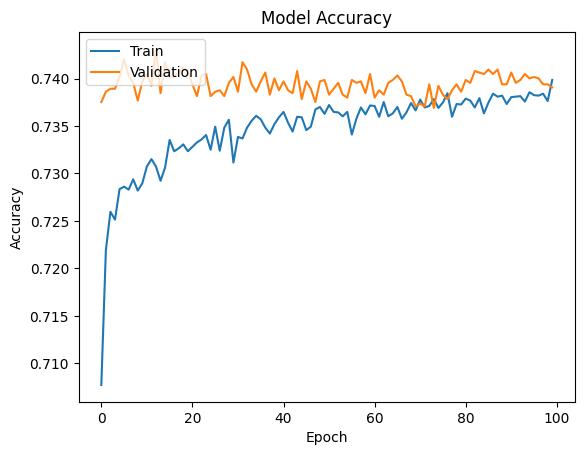

In [44]:
# visualization
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [45]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5562 - accuracy: 0.7298 - 151ms/epoch - 565us/step
Loss: 0.5562098622322083, Accuracy: 0.7297959327697754


In [46]:
# Export our model to HDF5 file
import h5py
nn.save_weights('AlphabetSoupVentures_DefOptimized.h5')